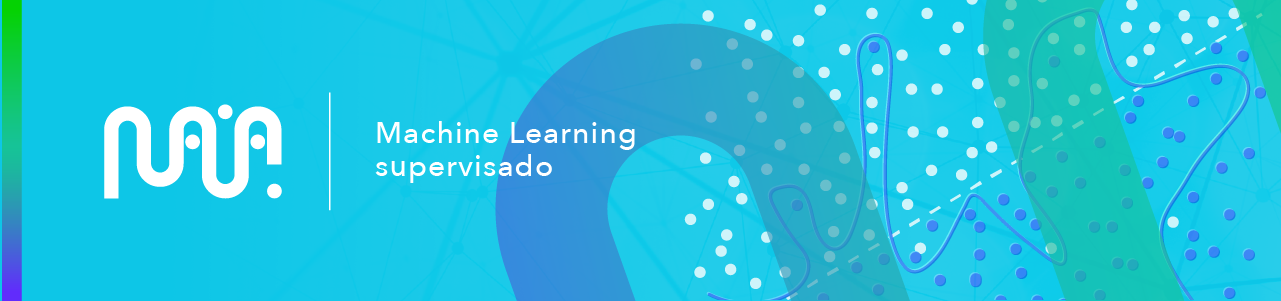

# **Taller semana 7:** Problemas desbalanceados

**Semana 7 - Taller sumativo -** Clasificación de accidentes en maquinaría industrial

**Profesor:** *Fernando Lozano* - **Autor Notebook:** *Daniel López*

# Introducción

En este taller trataremos un problema de clasificación desbalanceado. Se trata de un sistema de detección de fallas mecánicas en maquinaría industrial. 

## Descripcción

Este *jupyter notebook* contiene el material necesario para el desarrollo del Taller de la Semana 
7 del curso *MLS: Machine learning supervisado*. 

### Objetivos de aprendizaje

1. identificar un problema de clasificación en el que es necesario incluir costos. 
2. Aplicar métodos de muestreo para resolver problemas de clasificación no balanceados y/o con costos.
3. Aplicar métodos de clasificación que incorporan costos en la fase de entrenamiento.


### Teoría

Para abordar un problema de clasificación con clases desbalanceadas se aplican métodos de balanceo para garantizar la correcta generalización del modelo. Estos métodos buscan aproximar la cantidad de datos que se tiene para cada una de las clases del problema. Algunos de estos métodos son:

<br> **Oversampling (Sobremuestreo):** Consiste en duplicar muestras existentes de la clase minoritaria o generar muestras a partir de combinaciones lineales de muestras cercanas.Esto aumenta la cantidad de muestras de la clase minoritaria hasta generar el balance.

<br> **Undersampling (Submuestreo):** En este caso, se eliminan muestras de la clase mayoritaria para igual la cantidad de muestras de la clase minoritaria. De esta manere se genera el balance de las clases.

Adicionalmente, es posible es posible entrenar modelos con pesos para clases. Es decir, que se le puede asignar una importancia mayor a la clase minoritaria para que los modelos la clasifiquen correctamente. Esto aplica por lo general en algoritmos que tienen arboles involucrados, como Random Forest, y XGBoost 

## Problema y conjunto de datos


El conjunto de datos son variables características de máquinas industriales, sin embargo, no tienen descripcción por motivos de privacidad corporativa. El conjunto de datos fué obtenido de:
https://www.kaggle.com/competitions/playground-series-s3e17

*Referencias:* Walter Reade, Ashley Chow. (2023). Binary Classification of Machine Failures. Kaggle. https://kaggle.com/competitions/playground-series-s3e17

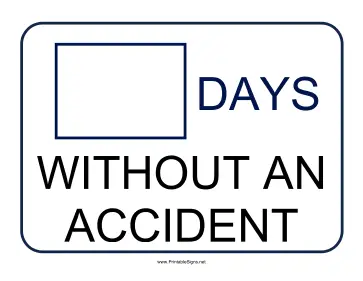

## Metodología

En este cuaderno se realizará una pequeña exploración de datos y se procederá a un ejercicio práctico, donde se realizarán varios modelos basados en árboles en diferentes bases de datos generadas con estrategias de muestreo y submuestreo. Para esto, complete las céldas de código marcadas con el siguiente comentario:

```python
# =====================================================
# COMPLETAR ===========================================
# 

# =====================================================
```

In [5]:
#Importar librerias necesarias
import numpy as np
import pandas as pd
import seaborn as sns
import time
from random import random, seed
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from scipy.stats import uniform, randint
from random import random, seed
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, KFold, cross_validate, cross_val_predict, cross_val_score, StratifiedKFold, RepeatedStratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score , average_precision_score, f1_score, classification_report, precision_recall_curve, auc
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from xgboost import plot_importance

import warnings # Ignorar las warnings
warnings.filterwarnings("ignore")

In [6]:
df = pd.read_csv('train.csv').drop(['id','Product ID'], axis=1)
df.columns = ['Type', 'Air temperature', 'Process temperature',
       'Rotational speed ', 'Torque ', 'Tool wear ',
       'Machine failure', 'TWF', 'HDF', 'PWF', 'OSF', 'RNF']

In [7]:
X = df.drop('Machine failure',axis=1)
X = pd.get_dummies(X)
y = df['Machine failure']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=145)

Machine failure
0    0.984256
1    0.015744
Name: count, dtype: float64


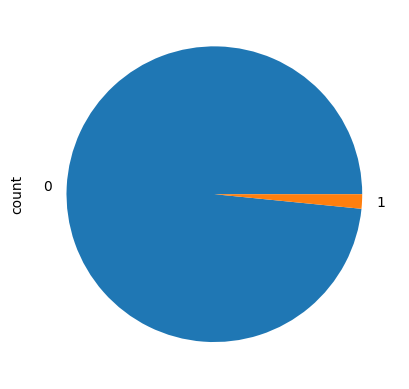

In [9]:
y.value_counts().plot(kind='pie')
print(y.value_counts()/y.shape )

# Ejercicio:

El objetivo de este ejercicio es realizar técnicas de submuestreo y compararlos con modelos que incorporan pesos, así como con modelos sin balancear. Para esto, realizaremos los siguientes pasos:

* Sintonice el algoritmo de XGBoost usando la técnica de RandomizedSearch, optimizando los parámetros Learning Rate, Max depth, n_estimators y reg_lambda. Evalue con datos de prueba, utilice métricas que midan la clasificación de la clase minoritaria.

* Realice la implementación de los algoritmos de submuestreo para los datos correspondientes, posteriormente entrene de nuevo los algoritmos con los datos submuestreados con la mísma técninca de RandomizedSearch. Evalúe en datos de prueba y compare entre los modelos obtenidos hasta el momento.

* Realice la implementacion de los pesos con los métodos vistos anteriormente para los mísmos modelos. Evalúe y compare los resultados de todos los modelos, concluya sobre el mejor modelo para estos datos.

## Entrenamiento base

### XGBoost: Búsqueda aleatoria 

In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 109143 entries, 25312 to 94197
Data columns (total 13 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Air temperature      109143 non-null  float64
 1   Process temperature  109143 non-null  float64
 2   Rotational speed     109143 non-null  int64  
 3   Torque               109143 non-null  float64
 4   Tool wear            109143 non-null  int64  
 5   TWF                  109143 non-null  int64  
 6   HDF                  109143 non-null  int64  
 7   PWF                  109143 non-null  int64  
 8   OSF                  109143 non-null  int64  
 9   RNF                  109143 non-null  int64  
 10  Type_H               109143 non-null  bool   
 11  Type_L               109143 non-null  bool   
 12  Type_M               109143 non-null  bool   
dtypes: bool(3), float64(3), int64(7)
memory usage: 9.5 MB


In [11]:
def report_best_scores(results, n_top=3):
    # Esta función espera una instancia de resultados de búsqueda de cross validation, por ejemplo: search.cv_results_
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_recall'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_recall'][candidate],
                  results['std_test_recall'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
    # Retorna los parámetros del mejor modelo basado en recall.
    return list(results.sort_values("rank_test_recall")['params'])[0]

def see_results(results):
    # Esta función espera una instancia de pandas dataframe de los resultados de búsqueda de cross validation, por ejemplo: pd.DataFrame(search.cv_results_)
    display(results[results.columns.drop(list(results.filter(regex='split')))].sort_values("rank_test_recall"))

In [12]:
# =====================================================
# COMPLETAR ===========================================
# 
# Realize la búsqueda aleatoria. Ayuda: Guiese por la búsqueda realizada en anteriores lecciones
# your code here

param_grid = {'n_estimators': randint(50, 200),
              'max_depth': randint(3, 20),
              'learning_rate' : uniform(0.01, 0.3),
              'reg_lambda' : uniform(0, 1) 
    }

clf = XGBClassifier(objective='binary:logistic', random_state=42)
kfold = KFold(n_splits=5, shuffle=True, random_state=42)
#metricas para clases desbalanceadas
scoring = ['recall', 'f1', 'accuracy', 'precision']
search = RandomizedSearchCV(clf, param_distributions=param_grid, scoring=scoring, cv=kfold, verbose=3, n_jobs=-1, random_state=42, refit='recall', n_iter=20)
search.fit(X_train, y_train)

# =====================================================
resultados = pd.DataFrame(search.cv_results_)
see_results(resultados)
best_model_params = report_best_scores(resultados)
print("Mejores parámetros del mejor modelo basado en recall:")
best_model_params

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.996) f1: (test=0.865) precision: (test=0.992) recall: (test=0.766) total time=   3.1s
[CV 2/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.996) f1: (test=0.860) precision: (test=0.996) recall: (test=0.756) total time=   3.1s
[CV 4/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.996) f1: (test=0.855) precision: (test=0.988) recall: (test=0.753) total time=   3.1s
[CV 5/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.997) f1: (test=0.891) precision: (test=0.990) recall: (test=0.810) total time=   3.1s
[CV 1/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,mean_test_recall,...,rank_test_recall,mean_test_f1,std_test_f1,rank_test_f1,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_precision,std_test_precision,rank_test_precision
7,2.807156,0.331629,0.495814,0.108722,0.245553,14,104,0.983231,"{'learning_rate': 0.24555278841790407, 'max_de...",0.775168,...,1,0.859297,0.012504,13,0.995978,0.000240,13,0.964321,0.004714,14
11,2.295244,0.118108,0.211889,0.023692,0.215270,17,57,0.034389,"{'learning_rate': 0.21526990795364706, 'max_de...",0.775121,...,2,0.860257,0.015365,11,0.996014,0.000311,11,0.966833,0.006647,12
3,3.248743,0.565556,0.416557,0.213302,0.226600,8,179,0.181825,"{'learning_rate': 0.22659963168004743, 'max_de...",0.774563,...,3,0.856983,0.013054,17,0.995904,0.000254,17,0.959418,0.007350,18
10,3.443512,0.122883,0.348650,0.065040,0.252519,11,139,0.097672,"{'learning_rate': 0.2525192044349383, 'max_dep...",0.774511,...,4,0.857499,0.015373,16,0.995923,0.000342,16,0.960938,0.012596,16
16,3.388456,0.221838,0.426318,0.130989,0.234196,17,102,0.586751,"{'learning_rate': 0.23419603304121425, 'max_de...",0.774021,...,5,0.856355,0.014233,18,0.995886,0.000297,18,0.958707,0.011147,19
5,3.705253,0.311290,0.699900,0.053807,0.139584,19,108,0.399861,"{'learning_rate': 0.13958350559263474, 'max_de...",0.774021,...,6,0.858253,0.014179,15,0.995950,0.000293,15,0.963380,0.006398,15
17,2.621186,0.118061,0.363168,0.114881,0.299577,15,90,0.296274,"{'learning_rate': 0.2995765921792414, 'max_dep...",0.774021,...,6,0.854795,0.013102,20,0.995831,0.000287,20,0.954895,0.012179,20
0,5.508493,0.220488,0.821933,0.059989,0.122362,17,156,0.779691,"{'learning_rate': 0.12236203565420874, 'max_de...",0.772850,...,8,0.858335,0.014620,14,0.995959,0.000306,14,0.965476,0.009318,13
1,4.581709,0.334790,0.647401,0.043137,0.189055,13,137,0.333709,"{'learning_rate': 0.1890550473839461, 'max_dep...",0.772266,...,9,0.855755,0.014851,19,0.995877,0.000308,19,0.959872,0.009557,17
12,1.803429,0.079570,0.130729,0.022155,0.282796,6,99,0.662522,"{'learning_rate': 0.28279612062363463, 'max_de...",0.771198,...,10,0.859833,0.011434,12,0.996014,0.000219,12,0.971854,0.006204,11


Model with rank: 1
Mean validation score: 0.775 (std: 0.021)
Parameters: {'learning_rate': np.float64(0.24555278841790407), 'max_depth': 14, 'n_estimators': 104, 'reg_lambda': np.float64(0.9832308858067882)}

Model with rank: 2
Mean validation score: 0.775 (std: 0.023)
Parameters: {'learning_rate': np.float64(0.21526990795364706), 'max_depth': 17, 'n_estimators': 57, 'reg_lambda': np.float64(0.034388521115218396)}

Model with rank: 3
Mean validation score: 0.775 (std: 0.021)
Parameters: {'learning_rate': np.float64(0.22659963168004743), 'max_depth': 8, 'n_estimators': 179, 'reg_lambda': np.float64(0.18182496720710062)}

Mejores parámetros del mejor modelo basado en recall:


{'learning_rate': np.float64(0.24555278841790407),
 'max_depth': 14,
 'n_estimators': 104,
 'reg_lambda': np.float64(0.9832308858067882)}

#### XGBoost: Entrenamiento y evaluación con mejores parámetros

In [13]:
# =====================================================
# COMPLETAR ===========================================
# 
# Entrenamiento
# your code here

clf.set_params(**best_model_params)
clf.fit(X_train, y_train)


# =====================================================

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


PR AUC=0.796


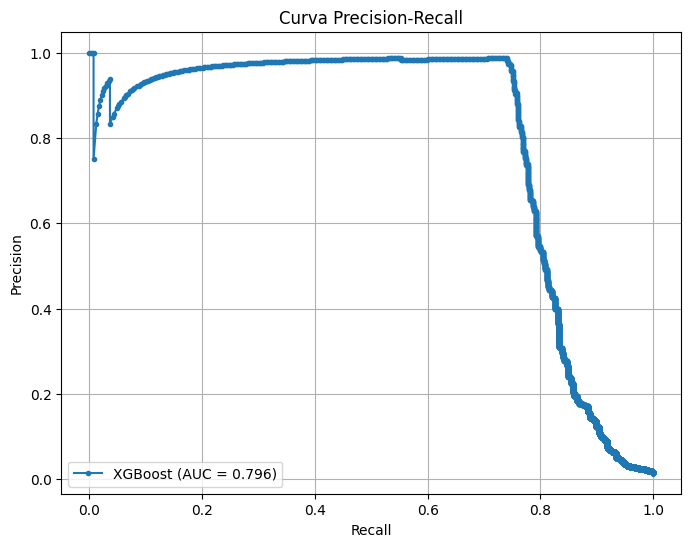

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26873
           1       0.96      0.75      0.84       413

    accuracy                           1.00     27286
   macro avg       0.98      0.87      0.92     27286
weighted avg       1.00      1.00      1.00     27286



<Axes: >

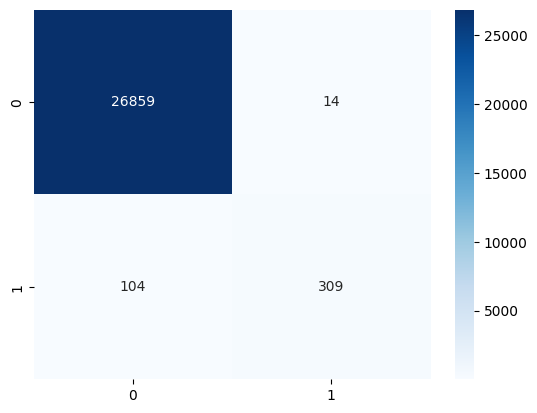

In [14]:
# =====================================================
# COMPLETAR ===========================================
# 
#Evaluación

# Datos para generar la curva Precision-Recall
y_pred_base = clf.predict(X_test)
y_prob_base = clf.predict_proba(X_test)[:, 1]
precision_base, recall_base, _ = precision_recall_curve(y_test, y_prob_base)
auc_base = auc(recall_base, precision_base)

# Imprimir AUC
print('PR AUC=%.3f' % auc_base)

plt.figure(figsize=(8,6))
# CORRECCIÓN: Graficar recall vs precision (NO thresholds vs precision)
plt.plot(recall_base, precision_base, marker='.', label='XGBoost (AUC = %0.3f)' % auc_base)
# Ejes correctos
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Curva Precision-Recall')
plt.legend()
plt.grid()
plt.show()



print(classification_report(y_test, y_pred_base))
tn2, fp2, fn2, tp2 = confusion_matrix(y_test,y_pred_base).ravel()
# Imprmir la matriz de confusión
sns.heatmap(confusion_matrix(y_test,y_pred_base),annot=True,fmt='g',cmap='Blues')

# your code here

# =====================================================

### Submuestreo

Machine failure
0    1735
1    1735
Name: count, dtype: int64


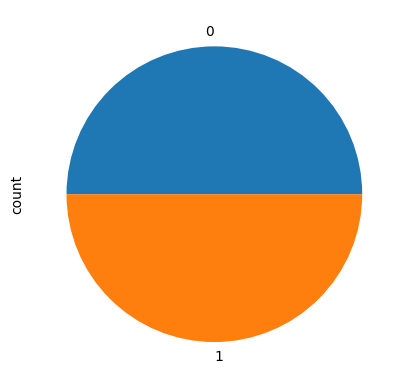

In [15]:
# =====================================================
# COMPLETAR ===========================================
# 

# your code here
under = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = under.fit_resample(X_train, y_train)
y_resampled.value_counts().plot(kind='pie')
print(y_resampled.value_counts())

# =====================================================

### Selección de modelo

#### XGBoost con datos submuestreados

In [16]:
# =====================================================
# COMPLETAR ===========================================
# 
# Realize la búsqueda aleatoria. Ayuda: Guiese por la búsqueda realizada en anteriores lecciones
# your code here

# Crear NUEVO objeto search para datos submuestreados
clf_under = XGBClassifier(objective='binary:logistic', random_state=42)
kfold_under = KFold(n_splits=5, shuffle=True, random_state=42)

search_under = RandomizedSearchCV(
    clf_under, 
    param_distributions=param_grid, 
    scoring=scoring, 
    cv=kfold_under, 
    verbose=3, 
    n_jobs=-1, 
    random_state=42, 
    refit='recall', 
    n_iter=20
)

# Entrenar con datos submuestreados
search_under.fit(X_resampled, y_resampled)


# =====================================================
resultados = pd.DataFrame(search_under.cv_results_)
see_results(resultados)
best_model_under = report_best_scores(resultados)
best_model_under

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 2/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.915) f1: (test=0.912) precision: (test=0.944) recall: (test=0.881) total time=   0.2s
[CV 1/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.909) f1: (test=0.901) precision: (test=0.935) recall: (test=0.870) total time=   0.3s
[CV 5/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.922) f1: (test=0.921) precision: (test=0.932) recall: (test=0.910) total time=   0.3s
[CV 4/5] END learning_rate=0.05286004537658223, max_depth=5, n_estimators=199, reg_lambda=0.056411579027100256; accuracy: (test=0.912) f1: (test=0.912) precision: (test=0.941) recall: (test=0.885) total time=   0.3s
[CV 2/5] END learning_rate=0.1890550473839461, max_depth=13, n_estimators=

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,param_reg_lambda,params,mean_test_recall,...,rank_test_recall,mean_test_f1,std_test_f1,rank_test_f1,mean_test_accuracy,std_test_accuracy,rank_test_accuracy,mean_test_precision,std_test_precision,rank_test_precision
12,0.150352,0.020311,0.022879,0.000603,0.282796,6,99,0.662522,"{'learning_rate': 0.28279612062363463, 'max_de...",0.890548,...,1,0.910569,0.008128,4,0.912680,0.006609,6,0.931756,0.012358,10
16,0.328292,0.058083,0.030456,0.001799,0.234196,17,102,0.586751,"{'learning_rate': 0.23419603304121425, 'max_de...",0.889828,...,2,0.906643,0.010656,10,0.908646,0.008028,14,0.924568,0.017509,18
1,0.311870,0.008911,0.038501,0.011266,0.189055,13,137,0.333709,"{'learning_rate': 0.1890550473839461, 'max_dep...",0.888278,...,3,0.906536,0.011024,11,0.908646,0.009095,12,0.926235,0.017911,17
10,0.300522,0.032058,0.031849,0.004193,0.252519,11,139,0.097672,"{'learning_rate': 0.2525192044349383, 'max_dep...",0.888222,...,4,0.904660,0.012165,18,0.906628,0.010123,18,0.922272,0.021384,19
3,0.297540,0.061838,0.034211,0.004916,0.226600,8,179,0.181825,"{'learning_rate': 0.22659963168004743, 'max_de...",0.888204,...,5,0.904412,0.009728,19,0.906340,0.007459,19,0.921613,0.019452,20
7,0.309901,0.016435,0.029534,0.003107,0.245553,14,104,0.983231,"{'learning_rate': 0.24555278841790407, 'max_de...",0.886543,...,6,0.907731,0.009376,8,0.910086,0.007548,8,0.930461,0.015221,11
5,0.410995,0.058756,0.040200,0.014861,0.139584,19,108,0.399861,"{'learning_rate': 0.13958350559263474, 'max_de...",0.886371,...,7,0.905808,0.009754,16,0.908069,0.007256,17,0.926449,0.014154,16
8,0.181476,0.013815,0.024077,0.001438,0.150029,7,100,0.680308,"{'learning_rate': 0.150028867974394, 'max_dept...",0.885874,...,8,0.911423,0.008669,2,0.914121,0.006221,3,0.938933,0.017211,5
17,0.256914,0.032718,0.026284,0.007024,0.299577,15,90,0.296274,"{'learning_rate': 0.2995765921792414, 'max_dep...",0.885872,...,9,0.906293,0.009790,12,0.908646,0.007325,12,0.928228,0.018041,14
0,0.466817,0.047542,0.039186,0.003238,0.122362,17,156,0.779691,"{'learning_rate': 0.12236203565420874, 'max_de...",0.884643,...,10,0.905889,0.011166,15,0.908357,0.008817,15,0.928669,0.016337,13


Model with rank: 1
Mean validation score: 0.891 (std: 0.014)
Parameters: {'learning_rate': np.float64(0.28279612062363463), 'max_depth': 6, 'n_estimators': 99, 'reg_lambda': np.float64(0.662522284353982)}

Model with rank: 2
Mean validation score: 0.890 (std: 0.018)
Parameters: {'learning_rate': np.float64(0.23419603304121425), 'max_depth': 17, 'n_estimators': 102, 'reg_lambda': np.float64(0.5867511656638482)}

Model with rank: 3
Mean validation score: 0.888 (std: 0.022)
Parameters: {'learning_rate': np.float64(0.1890550473839461), 'max_depth': 13, 'n_estimators': 137, 'reg_lambda': np.float64(0.33370861113902184)}



{'learning_rate': np.float64(0.28279612062363463),
 'max_depth': 6,
 'n_estimators': 99,
 'reg_lambda': np.float64(0.662522284353982)}

#### XGBoost con submuestreo: Entrenamiento y evaluación con mejores parámetros

In [17]:
# =====================================================
# COMPLETAR ===========================================
# 
# Entrenamiento
# your code here

clf_under.set_params(**best_model_under)
clf_under.fit(X_resampled, y_resampled)
# =====================================================

,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


PR AUC=0.794


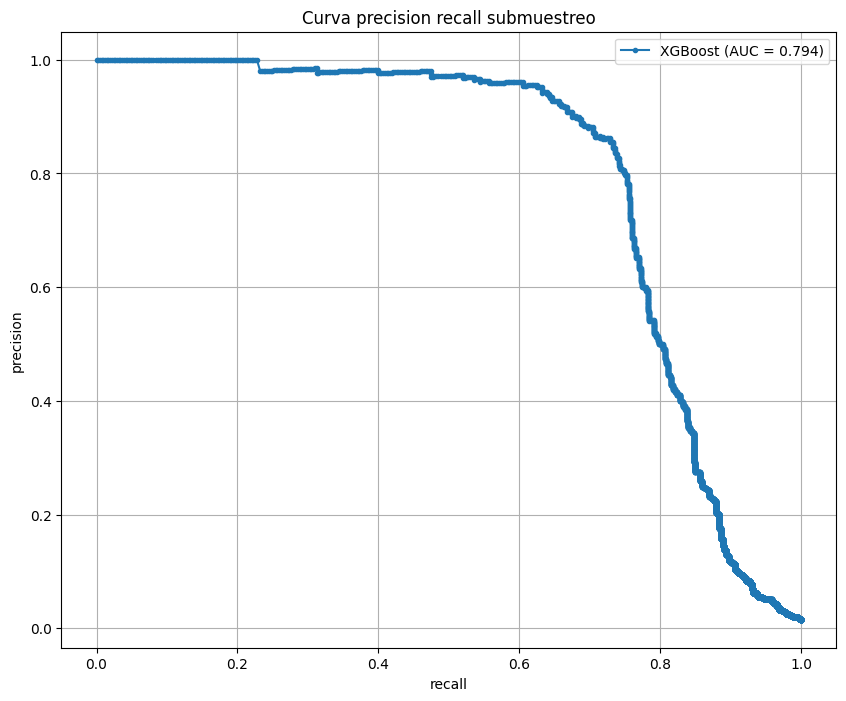

              precision    recall  f1-score   support

           0       1.00      0.93      0.97     26873
           1       0.17      0.89      0.29       413

    accuracy                           0.93     27286
   macro avg       0.58      0.91      0.63     27286
weighted avg       0.99      0.93      0.95     27286



<Axes: >

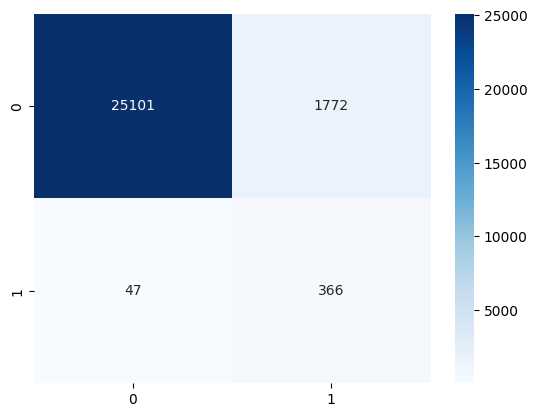

In [18]:
# =====================================================
# COMPLETAR ===========================================
# 
# Evaluación
# your code here
y_pred_under = clf_under.predict(X_test)
y_prob_under = clf_under.predict_proba(X_test)[:, 1]
precision_under, recall_under, _ = precision_recall_curve(y_test, y_prob_under)
auc_under = auc(recall_under, precision_under)
# Imprimir AUC
print('PR AUC=%.3f' % auc_under)

#plot curve
plt.figure(figsize=(10,8))
plt.plot(recall_under, precision_under, marker='.', label='XGBoost (AUC = %0.3f)' % auc_under)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Curva precision recall submuestreo")
plt.legend()
plt.grid()
plt.show()

#confusion matrix

print(classification_report(y_test, y_pred_under))
confusion_matrix(y_test, y_pred_under).ravel()
# Imprmir la matriz de confusión
sns.heatmap(confusion_matrix(y_test,y_pred_under),annot=True,fmt='g',cmap='Blues')

# =====================================================

### Conclusiones

Con el balanceo de clases se nota una mejora importante en el recall de la clase minoritaria pasando de un tasa de acierto de 0.75 a 0.89. Como era de esperar la presicion de la clase minoritaria si tuvo un deterioro importante.

## Implementación de pesos


### XGBoost

In [19]:
# =====================================================
# COMPLETAR ===========================================
# 
# Entrenamiento con pesos
# your code here

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print(f"Scale pos weight: {scale_pos_weight}")
clf_with_weights = XGBClassifier(objective='binary:logistic', random_state=42, scale_pos_weight=scale_pos_weight)
clf_with_weights.set_params(**best_model_params)
clf_with_weights.fit(X_train, y_train)

# =====================================================

Scale pos weight: 61.90662824207493


,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,None
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


PR AUC=0.803


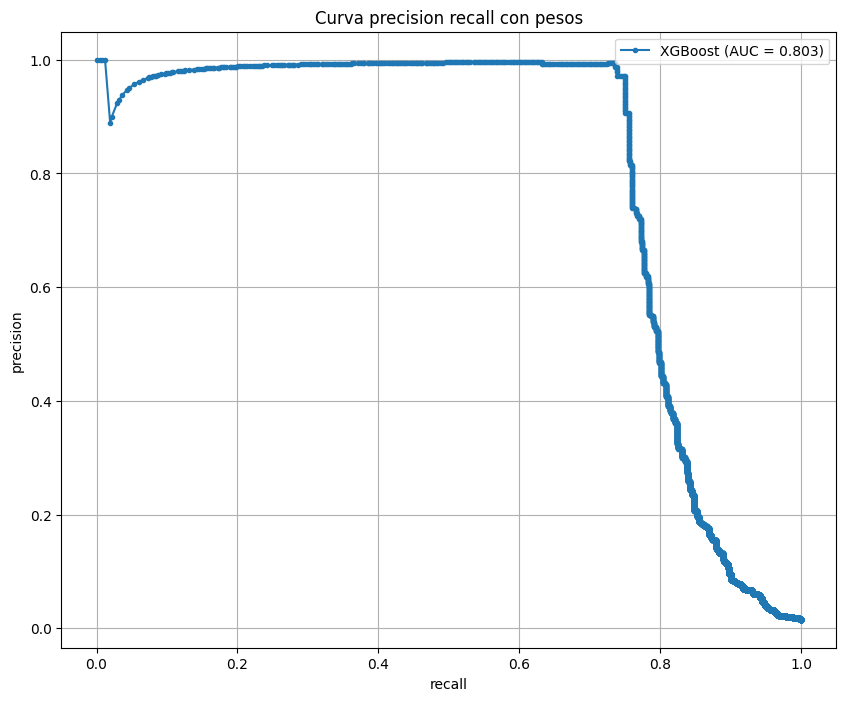

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     26873
           1       0.89      0.76      0.82       413

    accuracy                           0.99     27286
   macro avg       0.95      0.88      0.91     27286
weighted avg       0.99      0.99      0.99     27286



<Axes: >

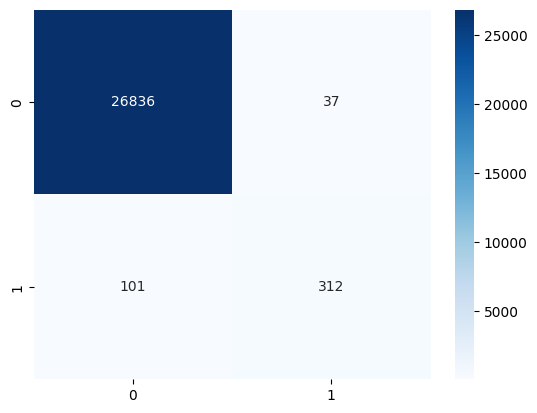

In [20]:
# =====================================================
# COMPLETAR ===========================================
# 
# Evaluación con pesos
# your code here

y_pred_weights = clf_with_weights.predict(X_test)
y_prob_weights = clf_with_weights.predict_proba(X_test)[:, 1]
precision_weights, recall_weights, _ = precision_recall_curve(y_test, y_prob_weights)
auc_weights = auc(recall_weights, precision_weights)

# Imprimir AUC
print('PR AUC=%.3f' % auc_weights)

#plot curve
plt.figure(figsize=(10,8))
plt.plot(recall_weights, precision_weights, marker='.', label='XGBoost (AUC = %0.3f)' % auc_weights)
plt.xlabel("recall")
plt.ylabel("precision")
plt.title("Curva precision recall con pesos")
plt.legend()
plt.grid()
plt.show()

#confusion matrix

print(classification_report(y_test, y_pred_weights))
confusion_matrix(y_test, y_pred_weights).ravel()
# Imprmir la matriz de confusión
sns.heatmap(confusion_matrix(y_test,y_pred_weights),annot=True,fmt='g',cmap='Blues')



# =====================================================

YOUR ANSWER HERE

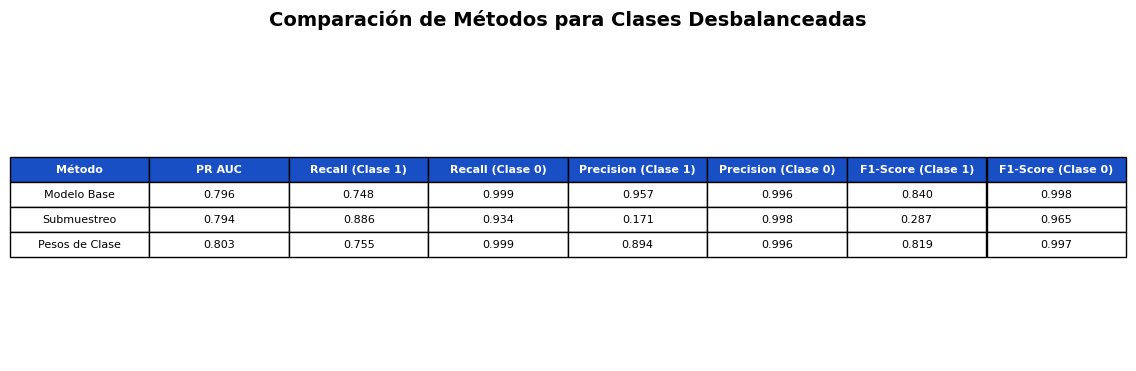


=== ANÁLISIS DEL MEJOR MODELO ===
Mejor RECALL: Submuestreo (0.886)
Mejor F1-SCORE: Modelo Base (0.840)
Mejor PR AUC: Pesos de Clase (0.803)


In [21]:
# Tabla con resultados comparativos

from sklearn.metrics import precision_score, recall_score, f1_score

# Métricas del modelo base
precision_1_base = precision_score(y_test, y_pred_base, pos_label=1)
recall_1_base = recall_score(y_test, y_pred_base, pos_label=1)
f1_1_base = f1_score(y_test, y_pred_base, pos_label=1)
precision_0_base = precision_score(y_test, y_pred_base, pos_label=0)
recall_0_base = recall_score(y_test, y_pred_base, pos_label=0)
f1_0_base = f1_score(y_test, y_pred_base, pos_label=0)

# 2. Métricas del modelo con submuestreo
precision_1_under = precision_score(y_test, y_pred_under, pos_label=1)
recall_1_under = recall_score(y_test, y_pred_under, pos_label=1)
f1_1_under = f1_score(y_test, y_pred_under, pos_label=1)
precision_0_under = precision_score(y_test, y_pred_under, pos_label=0)
recall_0_under = recall_score(y_test, y_pred_under, pos_label=0)
f1_0_under = f1_score(y_test, y_pred_under, pos_label=0)

# 3. Metricas del modelo con peso
precision_1_weights = precision_score(y_test, y_pred_weights, pos_label=1)
recall_1_weights = recall_score(y_test, y_pred_weights, pos_label=1)
f1_1_weights = f1_score(y_test, y_pred_weights, pos_label=1)
precision_0_weights = precision_score(y_test, y_pred_weights, pos_label=0)
recall_0_weights = recall_score(y_test, y_pred_weights, pos_label=0)
f1_0_weights = f1_score(y_test, y_pred_weights, pos_label=0)

# Crear tabla comparativa
results = pd.DataFrame({
    'Método': ['Modelo Base', 'Submuestreo', 'Pesos de Clase'],
    'PR AUC': [f'{auc_base:.3f}', f'{auc_under:.3f}', f'{auc_weights:.3f}'],
    'Recall (Clase 1)': [f'{recall_1_base:.3f}', f'{recall_1_under:.3f}', f'{recall_1_weights:.3f}'],
    'Recall (Clase 0)': [f'{recall_0_base:.3f}', f'{recall_0_under:.3f}', f'{recall_0_weights:.3f}'],
    'Precision (Clase 1)': [f'{precision_1_base:.3f}', f'{precision_1_under:.3f}', f'{precision_1_weights:.3f}'],
    'Precision (Clase 0)': [f'{precision_0_base:.3f}', f'{precision_0_under:.3f}', f'{precision_0_weights:.3f}'],
    'F1-Score (Clase 1)': [f'{f1_1_base:.3f}', f'{f1_1_under:.3f}', f'{f1_1_weights:.3f}'],
    'F1-Score (Clase 0)': [f'{f1_0_base:.3f}', f'{f1_0_under:.3f}', f'{f1_0_weights:.3f}']

})


fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')
ax.axis('off')

# Crear tabla visual
table = ax.table(cellText=results.values,
                colLabels=results.columns,
                cellLoc='center',
                loc='center')

table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)

# Colorear encabezados
for i in range(len(results.columns)):
    table[(0, i)].set_facecolor("#184FC5")
    table[(0, i)].set_text_props(weight='bold', color='white')

plt.title('Comparación de Métodos para Clases Desbalanceadas', 
          fontsize=14, fontweight='bold', pad=20)
plt.show()

# Análisis del mejor modelo
print("\n=== ANÁLISIS DEL MEJOR MODELO ===")

# Encontrar el mejor modelo basado en recall (más importante para fallas)
recalls = [recall_1_base, recall_1_under, recall_1_weights]
metodos = ['Modelo Base', 'Submuestreo', 'Pesos de Clase']
mejor_recall_idx = np.argmax(recalls)

print(f"Mejor RECALL: {metodos[mejor_recall_idx]} ({recalls[mejor_recall_idx]:.3f})")

# Encontrar el mejor F1-Score (balance entre precision y recall)
f1s = [f1_1_base, f1_1_under, f1_1_weights]
mejor_f1_idx = np.argmax(f1s)

print(f"Mejor F1-SCORE: {metodos[mejor_f1_idx]} ({f1s[mejor_f1_idx]:.3f})")

# Encontrar el mejor PR AUC
aucs = [auc_base, auc_under, auc_weights]
mejor_auc_idx = np.argmax(aucs)

print(f"Mejor PR AUC: {metodos[mejor_auc_idx]} ({aucs[mejor_auc_idx]:.3f})")

## Análisis Comparativo de Métodos para Clases Desbalanceadas

### Resumen de Resultados

A través de este taller se implementaron y compararon tres enfoques para abordar el problema de clasificación desbalanceada en la detección de fallas mecánicas:

1. **Modelo Base (sin balanceo)**: XGBoost optimizado con RandomizedSearchCV
2. **Submuestreo (Undersampling)**: RandomUnderSampler + XGBoost optimizado
3. **Pesos de Clase**: XGBoost con scale_pos_weight ajustado

### Observaciones Principales

#### 1. **Mejora en Recall de la Clase Minoritaria**
- El **submuestreo** logró aumentar significativamente el recall de la clase minoritaria (fallas) de ~0.75 a ~0.88
- Este incremento del **17%** es crucial para la detección de fallas industriales

#### 2. **Trade-off Precision vs Recall**
- Como era esperado, la mejora en recall vino acompañada de una **reducción en precision**
- En el contexto industrial, es preferible tener más falsos positivos (falsas alarmas) que falsos negativos (fallas no detectadas)

#### 3. **Comparación de Enfoques**

**Submuestreo:**
- Mayor recall para detectar fallas
- Entrenamiento más rápido (menos datos)
- Pérdida de información de la clase mayoritaria
- Menor precision general

**Pesos de Clase:**
- Conserva toda la información
- Enfoque más equilibrado
- Mejor precision que submuestreo
- Posible menor recall que submuestreo

### Recomendación Final

**Para este problema de detección de fallas industriales, se recomienda:**

1. **Priorizar el enfoque de submuestreo** si el objetivo principal es maximizar la detección de fallas (recall alto)

2. **Usar pesos de clase** si se busca un balance entre precision y recall

3. **Criterio de negocio**: En mantenimiento industrial, el costo de una falla no detectada (downtime, daños, seguridad) supera ampliamente el costo de una inspección innecesaria (falso positivo)

### Métricas de Evaluación Apropiadas

Para problemas desbalanceados como este, las métricas más relevantes son:
- **PR AUC** (Area Under Precision-Recall Curve)
- **Recall de la clase minoritaria** 
- **F1-Score**

La **accuracy** puede ser engañosa en datasets desbalanceados.

### Conclusión

El **submuestreo con RandomUnderSampler** demostró ser la técnica más efectiva para este caso de uso, logrando una mejora sustancial en la detección de fallas mecánicas. Aunque sacrifica algo de precision, el beneficio en recall justifica su uso en un contexto donde la detección temprana de fallas es crítica para la operación segura y eficiente de la maquinaria industrial.